# Evaluation metrics in NLP

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2019"

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [Classifier metrics](#Classifier-metrics)
  1. [Confusion matrix](#Confusion-matrix)
  1. [Accuracy](#Accuracy)
  1. [Precision](#Precision)
  1. [Recall](#Recall)
  1. [F scores](#F-scores)
  1. [Macro-averaged F scores](#Macro-averaged-F-scores)
  1. [Weighted F scores](#Weighted-F-scores)
  1. [Micro-averaged F scores](#Micro-averaged-F-scores)
  1. [Precision–recall curves](#Precision–recall-curves)
  1. [Average precision](#Average-precision)
  1. [Receiver Operating Characteristic (ROC) curve](#Receiver-Operating-Characteristic-(ROC)-curve)
1. [Regression metrics](#Regression-metrics)
  1. [Mean squared error](#Mean-squared-error)
  1. [R-squared scores](#R-squared-scores)
  1. [Pearson correlation](#Pearson-correlation)
  1. [Spearman rank correlation](#Spearman-rank-correlation)
1. [Sequence prediction](#Sequence-prediction)
  1. [Word error rate](#Word-error-rate)
  1. [BLEU scores](#BLEU-scores)
  1. [Perplexity](#Perplexity)
1. [Other resources](#Other-resources)

## Overview

1. Different evaluation metrics __encode different values__ and have __different biases and other weaknesses__. Thus, you should choose your metrics carefully, and motivate those choices when writing up and presenting your work.

1. This notebook reviews some of the most prominent evaluation metrics in NLP, seeking not only to define them, but also to articulate what values they encode and what their weaknesses are.

1. In your own work, __you shouldn't feel confined to these metrics__. Per item 1 above, you should feel that you have the freedom to motivate new metrics and specific uses of existing metrics, depending on what your goals are.

1. If you're working on an established problem, then you'll feel pressure from readers (and referees) to use the metrics that have already been used for the problem. This might be a compelling pressure. However, you should always feel free to argue against those cultural norms and motivate new ones. Areas can stagnate due to poor metrics, so we must be vigilant!

This notebook discusses prominent metrics in NLP evaluations. I've had to be selective to keep the notebook from growing too long and complex. I think the measures and considerations here are fairly representative of the issues that arise in NLP evaluation.

The scikit-learn [model evaluation usage guide](http://scikit-learn.org/stable/modules/model_evaluation.html) is excellent as a source of implementations, definitions, and references for a wide range of metrics for classification, regression, ranking, and clustering.

This notebook is the first in a two-part series on evaluation. Part 2 is on [evaluation methods](evaluation_methods.ipynb).

## Set-up

In [2]:
%matplotlib inline
from nltk.metrics.distance import edit_distance
from nltk.translate import bleu_score
import numpy as np
import pandas as pd
import scipy.stats
from sklearn import metrics

## Classifier metrics

### Confusion matrix

A confusion matrix gives a complete comparison of how the observed/gold labels compare to the labels predicted by a classifier.

`ex1 = `
<table>
<tr>
<th></th>
<th></th>
<th colspan=3 style="text-align:center">predicted</th>
</tr>
<tr>
<th></th>
<th></th>
<th>pos</th>
<th>neg</th>
<th>neutral</th>
</tr>
<tr>
<th rowspan=3>gold</th>
<th>pos</th>
<td>15</td>
<td>10</td>
<td>100</td>
</tr>
<tr>
<th>neg</th>
<td>10</td>
<td>15</td>
<td>10</td>
</tr>
<tr>
<th>neutral</th>
<td>10</td>
<td>100</td>
<td>1000</td>
</tr>
</table>

For classifiers that predict real values (scores, probabilities), it is important to remember that __a threshold was imposed to create these categorical predictions__. 

The position of this threshold can have a large impact on the overall assessment that uses the confusion matrix as an input. The default is to choose the class with the highest probability. This is so deeply ingrained that it is often not even mentioned. However, it might be inappropriate:

  1. We might care about the full distribution.
  1. Where the important class is very small relative to the others, any significant amount of positive probability for it might be important.

Metrics like [average precision](#Average-precision) explore this threshold as part of their evaluation procedure. 

This function creates the toy confusion matrices that we will use for illustrative examples:

In [3]:
def illustrative_confusion_matrix(data):
    classes = ['pos', 'neg', 'neutral']
    ex = pd.DataFrame(
        data,        
        columns=classes,
        index=classes)
    ex.index.name = "observed"
    return ex

In [4]:
ex1 = illustrative_confusion_matrix([
    [15,  10,  100],
    [10,  15,   10],
    [10, 100, 1000]])

### Accuracy

[Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) is the sum of the correct predictions divided by the sum of all predictions:

In [5]:
def accuracy(cm):
    return cm.values.diagonal().sum() / cm.values.sum()

Here's an illustrative confusion matrix:

`ex1 = `
<table>
<tr>
<th></th>
<th></th>
<th colspan=3 style="text-align:center">predicted</th>
</tr>
<tr>
<th></th>
<th></th>
<th>pos</th>
<th>neg</th>
<th>neutral</th>
</tr>
<tr>
<th rowspan=3>gold</th>
<th>pos</th>
<td style="background-color: green">15</td>
<td>10</td>
<td>100</td>
</tr>
<tr>
<th>neg</th>
<td>10</td>
<td style="background-color: green">15</td>
<td>10</td>
</tr>
<tr>
<th>neutral</th>
<td>10</td>
<td>100</td>
<td style="background-color: green">1000</td>
</tr>
</table>

In [6]:
accuracy(ex1)

0.8110236220472441

#### Accuracy bounds

[0, 1], with 0 the worst and 1 the best.

#### Value encoded by accuracy

Accuracy seems to directly encode a core value we have for classifiers – how often they are correct. In addition, the accuracy of a classifier on a test set will be negatively correlated with the [negative log (logistic, cross-entropy) loss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss), which is a common loss for classifiers. In this sense, these classifiers are optimizing for accuracy.

#### Weaknesses of accuracy

* Accuracy does not give per-class metrics for multi-class problems.

* Accuracy fails to control for size imbalances in the classes. For instance, consider the variant of the above in which the classifier guessed only __neutral__:

In [7]:
ex2 = illustrative_confusion_matrix([
    [0, 0,  125],
    [0, 0,   35], 
    [0, 0, 1110]])

In [8]:
ex2

,pos,neg,neutral
observed,,,
pos,0,0,125
neg,0,0,35
neutral,0,0,1110


Intuitively, this is a worse classifier than the one that produced `ex1`. Whereas `ex1` does well at __pos__ and __neg__ despite their small size, this classifier doesn't even try to get them right – it always predicts __neutral__. However, its accuracy is higher!

In [9]:
print(accuracy(ex1))
print(accuracy(ex2))

0.8110236220472441
0.8740157480314961


#### Related to accuracy

* Accuracy is inversely proportional to the [negative log (logistic, cross-entropy) loss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss) that many classifiers optimize:

$$
-\frac{1}{N} \sum_{i=1}^{N} \sum_{k=1}^{K} y_{i,k} \log(p_{i,k})
$$

* Accuracy can be related in a similar way to [KL divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence):    
$$
D_{\text{KL}}(y \parallel p) = 
    \sum _{k=1}^{K} y_{k} \log\left(\frac {y_{k}}{p_{k}}\right)
$$
  Where $y$ is a "one-hot vector" (a classification label) with $1$ at position $k$, this reduces to 
  $$
  \log\left(\frac{1}{p_{k}}\right) = -\log(p_{k})
  $$
  Thus, KL-divergence is an analogue of accuracy for soft labels.

### Precision

[Precision](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score) is the sum of the correct predictions divided by the sum of all guesses. This is a per-class notion; in our confusion matrices, it's the diagonal values divided by the column sums:

In [10]:
def precision(cm):
    return cm.values.diagonal() / cm.sum(axis=0)

`ex1 =`
<table>
<tr>
<th></th>
<th></th>
<th colspan=3 style="text-align:center">predicted</th>
</tr>
<tr>
<th></th>
<th></th>
<th>pos</th>
<th>neg</th>
<th>neutral</th>
</tr>
<tr>
<th rowspan=3>gold</th>
<th>pos</th>
<td style="background-color: #ADD8E6; font-weight: bold">15</td>
<td style="background-color: #00FFAA">10</td>
<td style="background-color: #FFC686">100</td>
</tr>
<tr>
<th>neg</th>
<td style="background-color: #ADD8E6">10</td>
<td style="background-color: #00FFAA; font-weight: bold">15</td>
<td style="background-color: #FFC686">10</td>
</tr>
<tr>
<th>neutral</th>
<td style="background-color: #ADD8E6">10</td>
<td style="background-color: #00FFAA">100</td>
<td style="background-color: #FFC686; font-weight: bold">1000</td>
</tr>
<tr>
<th></th>
<th>precision</th>
<td>0.43</td>
<td>0.12</td>
<td>0.90</td>
</tr>
</table>

In [11]:
precision(ex1)

pos        0.428571
neg        0.120000
neutral    0.900901
dtype: float64

For our problematic __all neutral__ classifier above, precision is strictly speaking undefined for __pos__ and __neg__:

In [12]:
ex2

,pos,neg,neutral
observed,,,
pos,0,0,125
neg,0,0,35
neutral,0,0,1110


In [13]:
precision(ex2)

pos             NaN
neg             NaN
neutral    0.874016
dtype: float64

It's common to see these `NaN` values mapped to 0.

#### Precision bounds

[0, 1], with 0 the worst and 1 the best. (Caveat: undefined values resulting from dividing by 0 need to be mapped to 0.)

#### Value encoded by precision

Precision encodes a _conservative_ value in penalizing incorrect guesses.

#### Weaknesses of precision

Precision's dangerous edge case is that one can achieve very high precision for a category by rarely guessing it. Consider, for example, the following classifier's flawless predictions for __pos__ and __neg__. These predictions are at the expense of __neutral__, but that is such a big class that it hardly matters to the precision for that class either.

In [14]:
ex3 = illustrative_confusion_matrix([
    [1, 0,  124], 
    [0, 1,   24], 
    [0, 0, 1110]])

In [15]:
ex3

,pos,neg,neutral
observed,,,
pos,1,0,124
neg,0,1,24
neutral,0,0,1110


In [16]:
precision(ex3)

pos        1.000000
neg        1.000000
neutral    0.882353
dtype: float64

These numbers mask the fact that this is a very poor classifier!

Compare with our less imbalanced `ex1`; for "perfect" precision on `pos` and `neg`, we incurred only a small drop in `neutral` here:

In [17]:
ex1

,pos,neg,neutral
observed,,,
pos,15,10,100
neg,10,15,10
neutral,10,100,1000


In [18]:
precision(ex1)

pos        0.428571
neg        0.120000
neutral    0.900901
dtype: float64

### Recall

[Recall](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score) is the sum of the correct predictions divided by the sum of all true instances. This is a per-class notion; in our confusion matrices, it's the diagonal values divided by the row sums. Recall is sometimes called the "true positive rate".

In [19]:
def recall(cm):
    return cm.values.diagonal() / cm.sum(axis=1)

`ex1 =`
<table>
<tr>
<th></th>
<th></th>
<th colspan=3 style="text-align:center">predicted</th>
<th></th>
</tr>
<tr>
<th></th>
<th></th>
<th>pos</th>
<th>neg</th>
<th>neutral</th>
<th>recall</th>    
</tr>
<tr>
<th rowspan=3>gold</th>
<th>pos</th>
<td style="background-color: #ADD8E6; font-weight: bold">15</td>
<td style="background-color: #ADD8E6">10</td>
<td style="background-color: #ADD8E6">100</td>
<td>0.12</td>    
</tr>
<tr>
<th>neg</th>
<td style="background-color: #00FFAA">10</td>
<td style="background-color: #00FFAA; font-weight: bold">15</td>
<td style="background-color: #00FFAA">10</td>
<td>0.43</td>    
</tr>
<tr>
<th>neutral</th>
<td style="background-color: #FFC686">10</td>
<td style="background-color: #FFC686">100</td>
<td style="background-color: #FFC686; font-weight: bold">1000</td>
<td>0.90</td>    
</tr>
</table>

In [20]:
recall(ex1)

observed
pos        0.120000
neg        0.428571
neutral    0.900901
dtype: float64

Recall trades off against precision. For instance, consider again `ex3`, in which the classifier was very conservative with __pos__ and __neg__:

`ex3 =`
<table>
<tr>
<th></th>
<th></th>
<th colspan=3 style="text-align:center">predicted</th>
<th></th>
</tr>
<tr>
<th></th>
<th></th>
<th>pos</th>
<th>neg</th>
<th>neutral</th>
<th>recall</th>    
</tr>
<tr>
<th rowspan=3>gold</th>
<th>pos</th>
<td style="background-color: #CCCCCC; font-weight: bold">1</td>
<td style="background-color: #CCCCCC">0</td>
<td style="background-color: #CCCCCC">124</td>
<td>0.008</td>    
</tr>
<tr>
<th>neg</th>
<td style="background-color: #CCCCCC">0</td>
<td style="background-color: #CCCCCC; font-weight: bold">1</td>
<td style="background-color: #CCCCCC">24</td>
<td>0.040</td>    
</tr>
<tr>
<th>neutral</th>
<td style="background-color: #CCCCCC">0</td>
<td style="background-color: #CCCCCC">0</td>
<td style="background-color: #CCCCCC; font-weight: bold">1110</td>
<td>1.000</td>    
</tr>
<tr>
<th></th>
<th>precision</th>
<td>1.00</td>
<td>1.00</td>
<td>0.88</td>
</tr>
</table>

#### Recall bounds

[0, 1], with 0 the worst and 1 the best.

#### Value encoded by recall

Recall encodes a _permissive_ value in penalizing only missed true cases.

#### Weaknesses of recall

Recall's dangerous edge case is that one can achieve very high recall for a category by always guessing it. This could mean a lot of incorrect guesses, but recall sees only the correct ones. You can see this in `ex3` above. The model did make some incorrect __neutral__ predictions, but it missed none, so it achieved perfect recall for that category.

`ex3 =`
<table>
<tr>
<th></th>
<th></th>
<th colspan=3 style="text-align:center">predicted</th>
<th></th>
</tr>
<tr>
<th></th>
<th></th>
<th>pos</th>
<th>neg</th>
<th>neutral</th>
<th>recall</th>    
</tr>
<tr>
<th rowspan=3>gold</th>
<th>pos</th>
<td style="background-color: #CCCCCC; font-weight: bold">1</td>
<td style="background-color: #CCCCCC">0</td>
<td style="background-color: #CCCCCC">124</td>
<td>0.008</td>    
</tr>
<tr>
<th>neg</th>
<td style="background-color: #CCCCCC">0</td>
<td style="background-color: #CCCCCC; font-weight: bold">1</td>
<td style="background-color: #CCCCCC">24</td>
<td>0.040</td>    
</tr>
<tr>
<th>neutral</th>
<td style="background-color: #CCCCCC">0</td>
<td style="background-color: #CCCCCC">0</td>
<td style="background-color: #CCCCCC; font-weight: bold">1110</td>
<td>1.000</td>    
</tr>
<tr>
<th></th>
<th>precision</th>
<td>1.00</td>
<td>1.00</td>
<td>0.88</td>
</tr>
</table>

### F scores

[F scores](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html#sklearn.metrics.fbeta_score) combine precision and recall via their harmonic mean, with a value $\beta$ that can be used to emphasize one or the other. Like precision and recall, this is a per-category notion.

$$
(\beta^{2}+1) \cdot \frac{\textbf{precision} \cdot
          \textbf{recall}}{(\beta^{2} \cdot \textbf{precision}) +
          \textbf{recall}}
$$

Where $\beta=1$, we have F1:

$$
2 \cdot \frac{\textbf{precision} \cdot \textbf{recall}}{\textbf{precision} + \textbf{recall}}
$$

In [21]:
def f_score(cm, beta):
    p = precision(cm)
    r = recall(cm)
    return (beta**2 + 1) * ((p * r) / ((beta**2 * p) + r))

In [22]:
def f1_score(cm):
    return f_score(cm, beta=1.0)

In [23]:
ex1

,pos,neg,neutral
observed,,,
pos,15,10,100
neg,10,15,10
neutral,10,100,1000


In [24]:
f1_score(ex1)

pos        0.187500
neg        0.187500
neutral    0.900901
dtype: float64

In [25]:
ex2

,pos,neg,neutral
observed,,,
pos,0,0,125
neg,0,0,35
neutral,0,0,1110


In [26]:
f1_score(ex2)

pos             NaN
neg             NaN
neutral    0.932773
dtype: float64

In [27]:
ex3

,pos,neg,neutral
observed,,,
pos,1,0,124
neg,0,1,24
neutral,0,0,1110


In [28]:
f1_score(ex3)

pos        0.015873
neg        0.076923
neutral    0.937500
dtype: float64

#### Bounds of F scores

[0, 1], with 0 the worst and 1 the best, and guaranteed to be between precision and recall.

#### Value encoded by F scores

The F$_{\beta}$ score for a class $K$ is an attempt to summarize how well the classifier's $K$ predictions align with the true instances of $K$. Alignment brings in both missed cases and incorrect predictions. Intuitively, precision and recall keep each other in check in the calculation. This idea runs through almost all robust classification metrics.

#### Weaknesses of F scores

* There is no normalization for the size of the dataset within $K$ or outside of it.

* For a given category $K$, the F$_{\beta}$ score for $K$ ignores  all the values that are off the row and column for $K$, which might be the majority of the data. This means that the individual scores for a category can be very misleading about the overall performance of the system. 

`ex1 = `
<table display="inline">
<tr>
<th></th>
<th></th>
<th colspan=3 style="text-align:center">predicted</th>
<th></th>      
</tr>
<tr>
<th></th>
<th></th>
<th>pos</th>
<th>neg</th>
<th>neutral</th>
<th>F1</th>    
</tr>
<tr>
<th rowspan=3>gold</th>
<th>pos</th>
<td>15</td>
<td>10</td>
<td>100</td>
<td>0.187</td>      
</tr>
<tr>
<th>neg</th>
<td>10</td>
<td>15</td>
<td>10</td>
<td>0.187</td>     
</tr>
<tr>
<th>neutral</th>
<td>10</td>
<td>100</td>
<td style="background-color: #D050D0">1,000</td>
<td>0.90</td>     
</tr>
</table>


`ex4 =`
<table display="inline">
<tr>
<th></th>
<th></th>
<th colspan=3 style="text-align:center">predicted</th>
<th></th>      
</tr>
<tr>
<th></th>
<th></th>
<th>pos</th>
<th>neg</th>
<th>neutral</th>
<th>F1</th>    
</tr>
<tr>
<th rowspan=3>gold</th>
<th>pos</th>
<td>15</td>
<td>10</td>
<td>100</td>
<td>0.187</td>      
</tr>
<tr>
<th>neg</th>
<td>10</td>
<td>15</td>
<td>10</td>
<td>0.187</td>     
</tr>
<tr>
<th>neutral</th>
<td>10</td>
<td>100</td>
<td style="background-color: #D050D0">100,000</td>
<td>0.999</td>     
</tr>
</table>

#### Related to F scores

* Dice similarity for binary vectors is sometimes used to assess how well a model has learned to identify a set of items. In this setting, [it is equivalent to the per-token F1 score](https://brenocon.com/blog/2012/04/f-scores-dice-and-jaccard-set-similarity/).

* The intuition behind F scores (balancing precision and recall) runs through many of the metrics discussed below.

### Macro-averaged F scores

The [macro-averaged F$_{\beta}$ score](http://scikit-learn.org/stable/modules/model_evaluation.html#multiclass-and-multilabel-classification) (macro F$_{\beta}$) is the mean of the F$_{\beta}$ score for each category:

In [29]:
def macro_f_score(cm, beta):
    return f_score(cm, beta).mean(skipna=False)

In [30]:
ex1

,pos,neg,neutral
observed,,,
pos,15,10,100
neg,10,15,10
neutral,10,100,1000


In [31]:
f1_score(ex1)

pos        0.187500
neg        0.187500
neutral    0.900901
dtype: float64

In [32]:
macro_f_score(ex1, beta=1)

0.42530030030030036

In [33]:
ex2

,pos,neg,neutral
observed,,,
pos,0,0,125
neg,0,0,35
neutral,0,0,1110


In [34]:
f1_score(ex2)

pos             NaN
neg             NaN
neutral    0.932773
dtype: float64

In [35]:
macro_f_score(ex2, beta=1)

nan

In [36]:
ex3

,pos,neg,neutral
observed,,,
pos,1,0,124
neg,0,1,24
neutral,0,0,1110


In [37]:
f1_score(ex3)

pos        0.015873
neg        0.076923
neutral    0.937500
dtype: float64

In [38]:
macro_f_score(ex3, beta=1)

0.34343203093203095

#### Bounds of macro-averaged F scores

[0, 1], with 0 the worst and 1 the best, and guaranteed to be between precision and recall.

#### Value encoded by macro-averaged F scores

Macro F$_{\beta}$ scores inherit the values of F$_{\beta}$ scores, and they additionally say that we care about all the classes equally regardless of their size. 

#### Weaknesses of macro-averaged F scores

In NLP, we typically care about modeling all of the classes well, so macro-F$_{\beta}$ scores often seem appropriate. However, this is also the source of their primary weaknesses:

* If a model is doing really well on a small class $K$, its high macro F$_{\beta}$ score might mask the fact that it mostly makes incorrect predictions outside of $K$. So F$_{\beta}$ scoring will make this kind of classifier look better than it is.

* Conversely, if a model does well on a very large class, its overall performance might be high even if it stumbles on some small classes. So F$_{\beta}$ scoring will make this kind of classifier look worse than it is, as measured by sheer number of good predictions.

### Weighted F scores

[Weighted F$_{\beta}$ scores](http://scikit-learn.org/stable/modules/model_evaluation.html#multiclass-and-multilabel-classification) average the per-category F$_{\beta}$ scores, but it's a weighted average based on the size of the classes in the observed/gold data:

In [39]:
def weighted_f_score(cm, beta):
    scores = f_score(cm, beta=beta).values
    weights = cm.sum(axis=1)
    return np.average(scores, weights=weights)

In [40]:
weighted_f_score(ex3, beta=1.0)

0.828993812624765

#### Bounds of weighted F scores

[0, 1], with 0 the worst and 1 the best, but without a guarantee that it will be between precision and recall.

#### Value encoded by weighted F scores

Weighted F$_{\beta}$ scores inherit the values of F$_{\beta}$ scores, and they additionally say that we want to weight the summary by the number of actual and predicted examples in each class. This will probably correspond well with how the classifier will perform, on a per example basis, on data with the same class distribution as the training data.

#### Weaknesses of weighted F scores

Large classes will dominate these calculations. Just like macro-averaging, this can make a classifier look artificially good or bad, depending on where its errors tend to occur.

### Micro-averaged F scores

[Micro-averaged F$_{\beta}$ scores](http://scikit-learn.org/stable/modules/model_evaluation.html#multiclass-and-multilabel-classification) (micro F$_{\beta}$ scores) add up the 2 $\times$ 2 confusion matrices for each category versus the rest, and then they calculate the F$_{\beta}$ scores, with the convention being that the positive class's F$_{\beta}$ score is reported. 

This function creates the 2 $\times$ 2 matrix for a category `cat` in a confusion matrix `cm`:

In [41]:
def cat_versus_rest(cm, cat):
    yes = cm.loc[cat, cat]
    yes_no = cm.loc[cat].sum() - yes
    no_yes = cm[cat].sum() - yes
    no = cm.values.sum() - yes - yes_no - no_yes
    return pd.DataFrame(
        [[yes,    yes_no], 
         [no_yes,    no]],
        columns=['yes', 'no'], 
        index=['yes', 'no'])

In [42]:
display(ex1)
display(cat_versus_rest(ex1, 'pos'))
display(cat_versus_rest(ex1, 'neg'))
display(cat_versus_rest(ex1, 'neutral'))

,pos,neg,neutral
observed,,,
pos,15,10,100
neg,10,15,10
neutral,10,100,1000


,yes,no
yes,15,110
no,20,1125


,yes,no
yes,15,20
no,110,1125


,yes,no
yes,1000,110
no,110,50


In [43]:
sum([cat_versus_rest(ex1, cat) for cat in ex1.index])

,yes,no
yes,1030,240
no,240,2300


For the micro F$_{\beta}$ score, we just add up these per-category confusion matrices and calculate the F$_{\beta}$ score:

In [44]:
def micro_f_score(cm, beta):
    c = sum([cat_versus_rest(cm, cat) for cat in cm.index])
    return f_score(c, beta=beta).loc['yes']

In [45]:
micro_f_score(ex1, beta=1.0)

0.8110236220472442

#### Bounds of micro-averaged F scores

[0, 1], with 0 the worst and 1 the best, and guaranteed to be between precision and recall.

#### Value encoded by micro-averaged F scores

* Micro F$_{\beta}$ scores inherit the values of weighted F$_{\beta}$ scores. (The resulting scores tend to be very similar.)

* For two-class problems, this has an intuitive interpretation in which precision and recall are defined in terms of correct and incorrect guesses ignoring the class. 

#### Weaknesses of micro-averaged F scores

The weaknesses too are the same as those of weighted F$_{\beta}$ scores, with the additional drawback that we actually get two potentially very different values, for the positive and negative classes, and we have to choose one to meet our goal of having a single summary number. (See the `'yes'` in the final line of `micro_f_score`.)

#### Related to micro-averaged F scores

* Micro-averaging is equivalent to accuracy.

* F1 is identical to both precision and recall on the 2 $\times$ 2 matrix that is the basis for the calculation.

### Precision–recall curves

I noted above that confusion matrices hide a threshold for turning probabilities/scores into predicted labels. With precision–recall curves, we finally address this.

A precision–recall curve is a method for summarizing the relationship between precision and recall for a binary classifier. 

The basis for this calculation is not the confusion matrix, but rather the raw scores or probabilities returned by the classifier. Normally, we use 0.5 as the threshold for saying that a prediction is positive. However, each distinct real value in the set of predictions is a potential threshold. The precision–recall curve explores this space.

Here's a basic implementation; [the sklearn version](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) is more flexible and so recommended for real experimental frameworks.

In [46]:
def precision_recall_curve(y, probs):
    """`y` is a list of labels, and `probs` is a list of predicted
    probabilities or predicted scores -- likely a column of the 
    output of `predict_proba` using an `sklearn` classifier.
    """
    thresholds = sorted(set(probs))
    data = []
    for t in thresholds:
        # Use `t` to create labels:
        pred = [1 if p >= t else 0 for p in probs]
        # Precision/recall analysis as usual, focused on
        # the positive class:
        cm = pd.DataFrame(metrics.confusion_matrix(y, pred))
        prec = precision(cm)[1]
        rec = recall(cm)[1]
        data.append((t, prec, rec))
    # For intuitive graphs, always include this end-point:
    data.append((None, 1, 0))
    return pd.DataFrame(
        data, columns=['threshold', 'precision', 'recall'])        

I'll illustrate with a hypothetical binary classification problem involving balanced classes:

In [47]:
y = np.random.choice((0, 1), size=1000, p=(0.5, 0.5))

Suppose our classifier is generally able to distinguish the two classes, but it never predicts a value above 0.4, so our usual methods of thresholding at 0.5 would make the classifier look very bad:

In [48]:
y_pred = [np.random.uniform(0.0, 0.3) if x == 0 else np.random.uniform(0.1, 0.4) 
         for x in y]

The precision–recall curve can help us identify the optimal threshold given whatever our real-world goals happen to be:

In [49]:
prc = precision_recall_curve(y, y_pred)

In [50]:
def plot_precision_recall_curve(prc):
    ax1 = prc.plot.scatter(x='recall', y='precision', legend=False)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1.1])
    ax1.set_ylabel("precision")
    ax2 = ax1.twiny()
    ax2.set_xticklabels(prc['threshold'].values[::100].round(3))
    _ = ax2.set_xlabel("threshold")

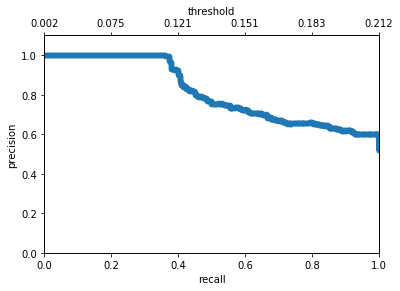

In [51]:
plot_precision_recall_curve(prc)

#### Value encoded by precision–recall curves

With precision–recall curves, we get a generalized perspective on F1 scores (and we could weight precision and recall differently to achieve the effects of `beta` for F scores more generally). These curves can be used, not only to assess a system, but also to identify an optimal decision boundary given external goals.    

#### Weaknesses of precision–recall curves

* Most implementations are limited to binary problems. The basic concepts are defined for multi-class problems, but it's very difficult to understand the resulting hyperplanes.

* There is no single statistic that does justice to the full curve, so this metric isn't useful on its own for guiding development and optimization. Indeed, opening up the decision threshold in this way really creates another hyperparameter that one has to worry about!

#### Related to precision–recall curves

* The [Receiver Operating Characteristic (ROC) curve](#Receiver-Operating-Characteristic-(ROC)-curve) is superficially similar to the precision–recall, but it compares recall with the false positive rate.

* [Average precision](#Average-precision), covered next, is a way of summarizing these curves with a single number.

### Average precision

Average precision is a method for summarizing the precision–recall curve. It does this by calculating the average precision weighted by the change in recall from step to step along the curve. 

Here is the calculation in terms of the data structures returned by `precision_recall_curve` above, in which (as in sklearn) the largest recall value is first:

$$\textbf{average-precision}(r, p) = \sum_{i=1}^{n} (r_{i} - r_{i+1})p_{i}$$

where $n$ is the increasing sequence of thresholds and the precision and recall vectors $p$ and $r$ are of length $n+1$. (We insert a final pair of values $p=1$ and $r=0$ in the precision–recall curve calculation, with no threshold for that point.)

In [52]:
def average_precision(p, r):
    total = 0.0
    for i in range(len(p)-1):
        total += (r[i] - r[i+1]) * p[i]
    return total

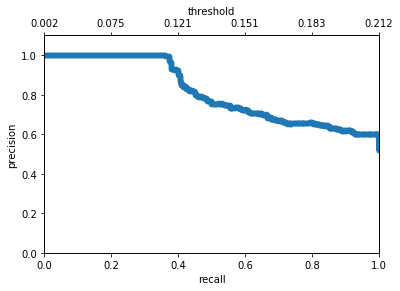

In [53]:
plot_precision_recall_curve(prc)

In [54]:
average_precision(prc['precision'].values, prc['recall'].values)

0.8137455350680958

#### Bounds of average precision

[0, 1], with 0 the worst and 1 the best.

#### Value encoded by average precision

This measure is very similar to the F1 score, in that it is seeking to balance precision and recall. Whereas the F1 score does this with the harmonic mean, average precision does it by making precision a function of recall.

#### Weaknesses of average precision

* An important weakness of this metric is cultural: it is often hard to tell whether a paper is reporting average precision or some interpolated variant thereof. The interpolated versions are meaningfully different and will tend to inflate scores. In any case, they are not comparable to the calculation defined above and implemented in `sklearn` as `sklearn.metrics.average_precision_score`.

* Unlike for precision–recall curves, we aren't strictly speaking limited to binary classification here. Since we aren't trying to visualize anything, we can do these calculations for multi-class problems. However, then we have to decide on how the precision and recall values will be combined for each step: macro-averaged, weighted, or micro-averaged, just as with F$_{\beta}$ scores. This introduces another meaningful design choice.

#### Related

* There are interpolated versions of this score, and some tasks/communities have even settled on specific versions as their standard metrics. All such measures should be approached with skepticism, since all of them can inflate scores artificially in specific cases. 

* [This blog post](https://roamanalytics.com/2016/09/07/stepping-away-from-linear-interpolation/) is an excellent discussion of the issues with linear interpolation. It proposes a step-wise interpolation procedure that is much less problematic. I believe the blog post and subsequent PR to `sklearn` led the `sklearn` developers to drop support for all interpolation mechanisms for this metric!

* Average precision as defined above is a discrete approximation of the [area under the precision–recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc). This is a separate measure often referred to as "AUC". In calculating AUC for a precision–recall curve, some kind of interpolation will be done, and this will generally produce exaggerated scores for the same reasons that interpolated average precison does.

### Receiver Operating Characteristic (ROC) curve

The Receiver Operating Characteristic (ROC) curve for a class $k$ depicts recall the __false positive rate__ (FPR) for $k$ as a function of the __recall__ for $k$. For instance, suppose we focus on $k$ as the positive class $A$:

$$
\begin{array}{r r r}
\hline
 & A & B \\
\hline
A & \text{TP}_{A} & \text{FN}_{A}\\
B & \text{FP}_{A} & \text{TN}_{A}\\
\hline
\end{array}
$$

The false positive rate is 

$$
\textbf{fpr}(A) = \frac{\text{FP}_{A}}{\text{FP}_{A} + \text{TN}_{A}}
$$

which is equivalent to 1 minus the recall for $B$ class. 

ROC curves are implemented in [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html). 

The area under the ROC curve is often used as a summary statistic: see [sklearn.metrics.roc_auc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score).

ROC is limited to binary problems.

#### Bounds of ROC

* For individual ROC calculations of recall divided fpr: [0, $\infty$), with larger better.
* For ROC AUC: [0, 1], with 1 the best.

#### Weaknesses of ROC

Recall that, for two classes $A$ and $B$, 

$$
\begin{array}{r r r}
\hline
 & A & B \\
\hline
A & \text{TP}_{A} & \text{FN}_{A}\\
B & \text{FP}_{A} & \text{TN}_{B}\\
\hline
\end{array}
$$

we can express ROC as comparing $\textbf{recall}(A)$ with $1.0 - \textbf{recall}(B)$.

This reveals a point of contrast with scores based in precision and recall: the entire table is used, whereas precision and recall for a class $k$ ignore the $\text{TN}_{k}$ values. Thus, whereas precision and recall for a class $k$ will be insensitive to changes in $\text{TN}_{k}$, ROC will be affected by such changes. The following individual ROC calculations help to bring this out:

$$
\begin{array}{r r r r r}
\hline
 & A & B & \textbf{F1} & \textbf{ROC}\\
\hline
A & 15 & 10 & 0.21 & 0.90 \\
B & 100 & {\color{blue}{50}} & 0.48 & 0.83 \\
\hline
\end{array}
\qquad
\begin{array}{r r r r r}
\hline
 & A & B & \textbf{F1} & \textbf{ROC} \\
\hline
A & 15 & 10 & 0.21 & 3.6 \\
B & 100 & {\color{blue}{500}} & 0.90 & 2.08  \\
\hline
\end{array}
$$

One might worry that the model on the right isn't better at identifying class $A$, even though its ROC value for $A$ is larger.

#### Related to ROC

ROC-based analysis is superficially similar to precision–recall curves and average precision, but we should have no expectation that the results will align, particularly in the presence of class imbalances like the one sketched above.

## Regression metrics

### Mean squared error

The [mean squared error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) is a summary of the distance between predicted and actual values:

$$
\textbf{mse}(y, \widehat{y}) = \frac{1}{N}\sum_{i=1}^{N} (y_{i} - \hat{y_{i}})^{2}
$$

In [55]:
def mean_squared_error(y_true, y_pred):
    diffs = (y_true - y_pred)**2
    return np.mean(diffs)

The raw distances `y_true - y_pred` are often called the __residuals__.

#### Bounds of mean-squared error

[0, $\infty$), with 0 the best.

#### Value encoded by mean-squared error

This measure seeks to summarize the errors made by a regression classifier. The smaller it is, the closer the model's predictions are to the truth. In this sense, it is intuitively like a counterpart to [accuracy](#Accuracy) for classifiers.

#### Weaknesses of mean-squared error

These values are highly dependent on scale of the output variables, making them very hard to interpret in isolation. One really needs a clear baseline, and scale-independent ways of comparing scores are also needed.

#### Related to mean-squared error

Scikit-learn implements a variety of closely related measures: [mean absolute error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error), [mean squared logarithmic error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error), and [median absolute error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.median_absolute_error.html#sklearn.metrics.median_absolute_error). I'd say that one should choose among these metrics based on how the output values are scaled and distributed. For instance:

* The median absolute error will be less sensitive to outliers than the others.
* Mean squared logarithmic error might be more appropriate where the outputs are not strictly speaking linearly increasing. 

### R-squared scores

The R$^{2}$ score is probably the most prominent method for summarizing regression model performance, in statistics, social sciences, and ML/NLP. This is the value that `sklearn`'s regression models deliver with their `score` functions.

$$
\textbf{r2}(y, \widehat{y}) =
    1.0 - \frac{
      \sum_{i}^{N} (y_{i} - \hat{y_{i}})^{2}     
    }{
       \sum_{i}^{N} (y_{i} - \mu)^{2}
    }
$$    
where $\mu$ is the mean of the gold values $y$.

In [56]:
def r2(y_true, y_pred):
    mu = y_true.mean()
    # Total sum of squares:
    total = ((y_true - mu)**2).sum()
    # Sum of squared errors:
    res = ((y_true - y_pred)**2).sum()    
    return 1.0 - (res / total)

#### Bounds of R-squared scores

[0, 1], with 0 the worst and 1 the best.

#### Value encoded by R-squared scores

The numerator in the R$^{2}$ calculation is the sum of errors: 

$$
\textbf{r2}(y, \widehat{y}) =
    1.0 - \frac{
      \sum_{i}^{N} (y_{i} - \hat{y_{i}})^{2}     
    }{
       \sum_{i}^{N} (y_{i} - \mu)^{2}
    }
$$ 

In the context of regular linear regression, the model's objective is to minimize the total sum of squares, which is the denominator in the calculation. Thus, R$^{2}$ is based in the ratio between what the model achieved and what its objective was, which is a measure of the goodness of fit of the model.

#### Weaknesses of R-squared scores

For comparative purposes, it's nice that R$^{2}$ is scaled between [0, 1]; as noted above, this lack of scaling makes mean squared error hard to interpret. But this also represents a trade-off: R$^{2}$ doesn't tell us about the magnitude of the errors.

#### Related to R-squared scores

* R$^{2}$ is [closely related to the squared Pearson correlation coefficient](https://en.wikipedia.org/wiki/Coefficient_of_determination#As_squared_correlation_coefficient).

* R$^{2}$ is closely related to the [explained variance](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html#sklearn.metrics.explained_variance_score), which is also defined in terms of a ratio of the residuals and the variation in the gold data. For explained variance, the numerator is the variance of the residuals and the denominator is the variance of the gold values.

* [Adjusted R$^{2}$](https://en.wikipedia.org/wiki/Coefficient_of_determination#Adjusted_R2) seeks to take into account the number of predictors in the model, to reduce the incentive to simply add more features in the hope of lucking into a better score. In ML/NLP, relatively little attention is paid to model complexity in this sense. The attitude is like: if you can improve your model by adding features, you might as well do that!

### Pearson correlation

The [Pearson correlation coefficient $\rho$](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between two vectors $y$ and $\widehat{y}$ of dimension $N$ is:

$$
\textbf{pearsonr}(y, \widehat{y}) = 
\frac{
  \sum_{i}^{N} (y_{i} - \mu_{y}) \cdot (\widehat{y}_{i} - \mu_{\widehat{y}})
}{
  \sum_{i}^{N} (y_{i} - \mu_{y})^{2} \cdot (\widehat{y}_{i} - \mu_{\widehat{y}})^{2}
}
$$
where $\mu_{y}$ is the mean of $y$ and $\mu_{\widehat{y}}$ is the mean of $\widehat{y}$.

This is implemented as `scipy.stats.pearsonr`, which returns the coefficient and a p-value.

#### Bounds of Pearson correlations

$[-1, 1]$, where $-1$ is a complete negative linear correlation, $+1$ is a complete positive linear correlation, and $0$ is no linear correlation at all.

#### Weaknesses of Pearson correlation

Pearson correlations are highly sensitive to the magnitude of the differences between the gold and predicted values. As a result, they are also very sensitive to outliers. 

#### Related to Pearson correlation

* For comparing gold values $y$ and predicted values $\widehat{y}$, Pearson correlation is equivalent to a linear regression using $\widehat{y}$ and a bias term to predict $y$. [See this great blog post for details.](https://lindeloev.github.io/tests-as-linear/)

* [As noted above](#Related-to-R-squared-scores), there is also a close relationship to R-squared values.

### Spearman rank correlation

The Spearman rank correlation coefficient between between two vectors $y$ and $\widehat{y}$ of dimension $N$ is the Pearson coefficient with all of the data mapped to their ranks.

It is implemented as `scipy.stats.spearmanr`, which returns the coefficient and a p-value.

In [57]:
corr_df = pd.DataFrame({
    'y1': np.random.uniform(-10, 10, size=1000),
    'y2': np.random.uniform(-10, 10, size=1000)})

In [58]:
scipy.stats.spearmanr(corr_df['y1'], corr_df['y2'])

SpearmanrResult(correlation=0.07827534627534627, pvalue=0.0132868180571953)

In [59]:
scipy.stats.pearsonr(corr_df['y1'].rank(), corr_df['y2'].rank())

(0.07827534627534627, 0.013286818057202079)

#### Bounds of Spearman rank correlations

$[-1, 1]$, where $-1$ is a complete negative linear correlation, $+1$ is a complete positive linear correlation, and $0$ is no linear correlation at all.

#### Weaknesses of Spearman rank correlation

Unlike Pearson, Spearman is not sensitive to the magnitude of the differences. In fact, it's invariant under all monotonic rescaling, since the values are converted to ranks. This also makes it less sensitive to outliers than Pearson.

Of course, these strengths become weaknesses in domains where the raw differences do matter. That said, in most NLU contexts, Spearman will be a good conservative choice for system assessment.

#### Related to Spearman rank correlation

For comparing gold values $y$ and predicted values $\widehat{y}$, Pearson correlation is equivalent to a linear regression using $\textbf{rank}(\widehat{y})$ and a bias term to predict $\textbf{rank}(y)$. [See this great blog post for details.](https://lindeloev.github.io/tests-as-linear/)

## Sequence prediction

Sequence prediction metrics all seek to summarize and quantify the extent to which a model has managed to reproduce, or accurately match, some gold standard sequences. Such problems arise throughout NLP. Examples: 

1. Mapping speech signals to their desired transcriptions.
1. Mapping texts in a language $L_{1}$ to their translations in a distinct language or dialect $L_{2}$.
1. Mapping input dialogue acts to their desired responses.
1. Mapping a sentence to one of its paraphrases.
1. Mapping real-world scenes or contexts (non-linguistic) to descriptions of them (linguistic).

Evaluations is very challenging because the relationships tend to be __many-to-one__: a given sentence might have multiple suitable translations; a given dialogue act will always have numerous felicitous responses; any scene can be described in multiple ways; and so forth. The most constrained of these problems is the speech-to-text case in 1, but even that one has indeterminacy in real-world contexts (humans often disagree about how to transcribe spoken language).

### Word error rate

The [word error rate](https://en.wikipedia.org/wiki/Word_error_rate) (WER) metric is a word-level, length-normalized measure of [Levenshtein string-edit distance](https://en.wikipedia.org/wiki/Levenshtein_distance):

In [60]:
def wer(seq_true, seq_pred):
    d = edit_distance(seq_true, seq_pred)
    return d / len(seq_true)    

In [61]:
wer(['A', 'B', 'C'], ['A', 'A', 'C'])

0.3333333333333333

In [62]:
wer(['A', 'B', 'C', 'D'], ['A', 'A', 'C', 'D'])

0.25

To calculate this over the entire test-set, one gets the edit-distances for each gold–predicted pair and normalizes these by the length of all the gold examples, rather than normalizing each case:

In [63]:
def corpus_wer(y_true, y_pred):
    dists = [edit_distance(seq_true, seq_pred) 
             for seq_true, seq_pred in zip(y_true, y_pred)]
    lengths = [len(seq) for seq in y_true]
    return sum(dists) / sum(lengths)

This gives a single summary value for the entire set of errors.

#### Bounds of word error rate

$[0, \infty)$, where 0 is best. (The lack of a finite upper bound derives from the fact that the normalizing constant is given by the true sequences, and the predicted sequences can differ from them in any conceivable way in principle.)

#### Value encoded by word error rate

This method says that our desired notion of closeness or accuracy can be operationalized in terms of the low-level operations of insertion, deletion, and substitution. The guiding intuition is very much like that of F scores.

#### Weaknesses of word error rate

The value encoded reveals a potential weakness in certain domains. Roughly, the more __semantic__ the task, the less appropriate WER is likely to be. 

For example, adding a negation to a sentence will radically change its meaning but incur only a small WER penalty, whereas passivizing a sentence (_Kim won the race_ &rarr; _The race was won by Kim_) will hardly change its meaning at all but incur a large WER penalty. 

See also [Liu et al. 2016](https://www.aclweb.org/anthology/D16-1230) for similar arguments in the context of dialogue generation.

#### Related to word error rate

* WER can be thought of as a family of different metrics varying in the notion of edit distance that they employ.

* The Word Accuracy Rate is 1.0 minus the WER, which, despits its name, is intuitively more like [recall](#Recall) than [accuracy](#Accuracy).

### BLEU scores

BLEU (Bilingual Evaluation Understudy) scores were originally developed in the context of machine translation, but they are applied in other generation tasks as well. For BLEU scoring, we require a set of gold outputs. The metric has two main components:

* __Modified n-gram precision__: A direct application of precision would divide the number of correct n-grams in the predicted output (n-grams that appear in any translation) by the number of n-grams in the predicted output. This has a degenerate solution in which the predicted output contains only one word. BLEU's modified version substitutes the actual count for each n-gram by the maximum number of times it appears in any translation.

* __Brevity penalty (BP)__: to avoid favoring outputs that are too short, a penalty is applied. Let $Y$ be the set of gold outputs, $\widehat{y}$ the predicted output, $c$ the length of the predicted output, and $r$ the smallest absolute difference between the length of $c$ and the length of any of its gold outputs in $Y$. Then:

$$\textbf{BP}(Y, \widehat{y}) =
\begin{cases}
1 & \textrm{ if } c > r \\
\exp(1 - \frac{r}{c}) & \textrm{otherwise}
\end{cases}$$

The BLEU score itself is typically a combination of modified n-gram precision for various $n$ (usually up to 4):

$$\textbf{BLEU}(Y, \widehat{y}) = \textbf{BP}(Y, \widehat{y}) \cdot 
    \exp\left(\sum_{n=1}^{N} w_{n} \cdot \log\left(\textbf{modified-precision}(Y, \widehat{y}, n\right)\right)$$

where $Y$ is the set of gold outputs, $\widehat{y}$ is the predicted output, and $w_{n}$ is a weight for each $n$-gram level (usually set to $1/N$).

NLTK has [implementations of Bleu scoring](http://www.nltk.org/_modules/nltk/translate/bleu_score.html) for the sentence-level, as defined above, and for the corpus level (`nltk.translate.bleu_score.corpus_bleu`). At the corpus level, it is typical to do a kind of [micro-averaging](#Micro-averaged-F-scores) of the modified precision scores and use a cumulative version of the brevity penalty.

#### Bounds of BLEU scores

[0, 1], with 1 being the best, though with no expectation that any system will achieve 1, since even sets of human-created translations do not reach this level.

#### Value encoded by BLEU scores

BLEU scores attempt to achieve the same balance between precision and recall that runs through the majority of the metrics discussed here. It has many affinities with [word error rate](#Word-error-rate), but seeks to accommodate the fact that there are typically multiple suitable outputs for a given input.

#### Weaknesses of BLEU scores

* [Callison-Burch et al. (2006)](http://www.aclweb.org/anthology/E06-1032) criticize BLEU as a machine translation metric on the grounds that it fails to correlate with human scoring of translations. They highlight its insensitivity  to n-gram order and its insensitivity to n-gram types (e.g., function vs. content words) as causes of this lack of correlation.

* [Liu et al. (2016)](https://www.aclweb.org/anthology/D16-1230) specifically argue against BLEU as a metric for assessing dialogue systems, based on a lack of correlation with human judgments about dialogue coherence.

#### Related to BLEU scores

There are many competitors/alternatives to BLEU, most proposed in the context of machine translation. Examples: [ROUGE](https://en.wikipedia.org/wiki/ROUGE_(metric), [METEOR](https://en.wikipedia.org/wiki/METEOR), [HyTER](http://www.aclweb.org/anthology/N12-1017), [Orange (smoothed Bleu)](http://www.aclweb.org/anthology/C04-1072).

### Perplexity

[Perplexity](https://en.wikipedia.org/wiki/Perplexity) is a common metric for directly assessing generation models by calculating the probability that they assign to sequences in the test data. It is based in a measure of average surprisal:

$$H(P, x) = -\frac{1}{m}\log_{2} P(x)$$

where $P$ is a model assigning probabilities to sequences and $x$ is a sequence.

Perplexity is then the exponent of this:

$$\textbf{perplexity}(P, x) = 2^{H(P, x)}$$

Using any base $n$ both in defining $H$ and as the base in $\textbf{perplexity}$ will lead to identical results.

Minimizing perplexity is equivalent to maximizing probability.

It is common to report per-token perplexity; here the averaging should be done in log-space to deliver a [geometric mean](https://en.wikipedia.org/wiki/Geometric_mean):

$$\textbf{token-perplexity}(P, x) = \exp\left(\frac{\log\textbf{perplexity}(P, x)}{\textbf{length}(x)}\right)$$

When averaging perplexity values obtained from all the sequences in a text corpus, one should again use the geometric mean:

$$\textbf{mean-perplexity}(P, X) = 
\exp\left(\frac{1}{m}\sum_{x\in X}\log(\textbf{token-perplexity}(P, x))\right)$$

for a set of $m$ examples $X$.

#### Bounds of perplexity

[1, $\infty$], where 1 is best.

#### Values encoded by perplexity

The guiding idea behind perplexity is that a good model will assign high probability to the sequences in the test data. This is an intuitive, expedient intrinsic evaluation, and it matches well with the objective for models trained with a cross-entropy or logistic objective.

#### Weaknesses of perplexity

* Perplexity is heavily dependent on the nature of the underlying vocabulary in the following sense: one can artificially lower one's perplexity by having a lot of `UNK` tokens in the training and test sets. Consider the extreme case in which _everything_ is mapped to `UNK` and perplexity is thus perfect on any test set. The more worrisome thing is that any amount of `UNK` usage side-steps the pervasive challenge of dealing with infrequent words.

* [As Hal Daumé discusses in this post](https://nlpers.blogspot.com/2014/05/perplexity-versus-error-rate-for.html), the perplexity metric imposes an artificial constrain that one's model outputs are probabilistic.

#### Related to perplexity

Perplexity is the inverse of probability and, [with some assumptions](http://www.cs.cmu.edu/~roni/11761/PreviousYearsHandouts/gauntlet.pdf), can be seen as an approximation of the cross-entropy between the model's predictions and the true underlying sequence probabilities.

## Other resources

The scikit-learn [model evaluation usage guide](http://scikit-learn.org/stable/modules/model_evaluation.html) is a great resource for metrics I didn't cover here. In particular:

* Clustering

* Ranking

* Inter-annotator agreement